##**Kasus 2: Mengoptimalkan Produksi di PT Agro Inovasi Bogor**

PT Agro Inovasi Bogor adalah sebuah produsen mesin pertanian terkemuka di Indonesia yang didirikan oleh alumni Institut Pertanian Bogor pada tahun 1990. Perusahaan ini dikenal dengan inovasi peralatan pertaniannya yang disesuaikan dengan kebutuhan petani lokal. Saat ini, perusahaan menghadapi tantangan dalam mengoptimalkan proses produksi untuk memenuhi permintaan pasar sambil memaksimalkan keuntungan.

Terdapat tujuh produk unggulan yang diproduksi: Pemanen Padi (PP1), Traktor Mini (TM2), Alat Penyemprot (AP3), Pengering Biji (PB4), Mesin Tanam (MT5), Penupuk Otomatis (PO6), dan Pemotong Rumput (PR7). Setiap produk memberikan kontribusi keuntungan yang berbeda-beda, seperti yang tercantum dalam Tabel Keuntungan di bawah ini  (dalam juta rupiah/ produk).

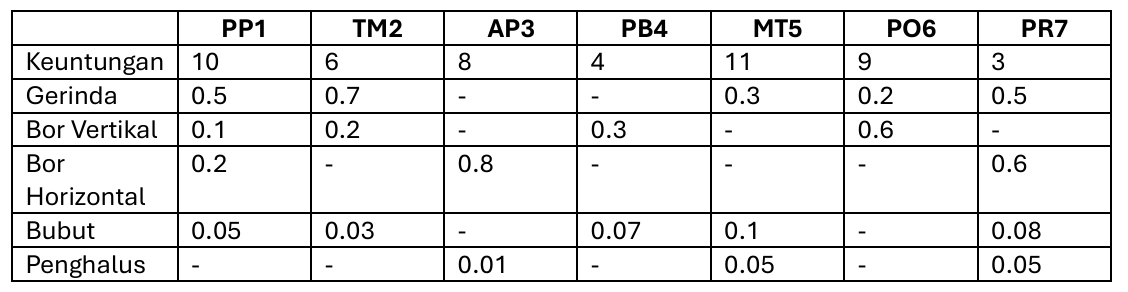

Setiap produk memerlukan waktu pemrosesan pada berbagai jenis mesin:
- 4 Mesin Gerinda
- 2 Bor Vertikal
- 3 Bor Horizontal
- 1 Mesin Bubut
- 1 Mesin Penghalus

Selain itu, perusahaan harus mematuhi jadwal pemeliharaan mesin yang telah ditetapkan untuk enam bulan ke depan:
- Januari: 1 Mesin Perata (dianggap sebagai Gerinda)
- Februari: 2 Bor Horizontal
- Maret: 1 Bubut
- April: 1 Bor Vertikal
- Mei: 1 Gerinda dan 1 Bor Vertikal
- Juni: 1 Penghalus dan 1 Bor Horizontal

Proyeksi penjualan atau batas pemasaran per produk per bulan ditunjukkan dalam Tabel Batas Pemasaran berikut:

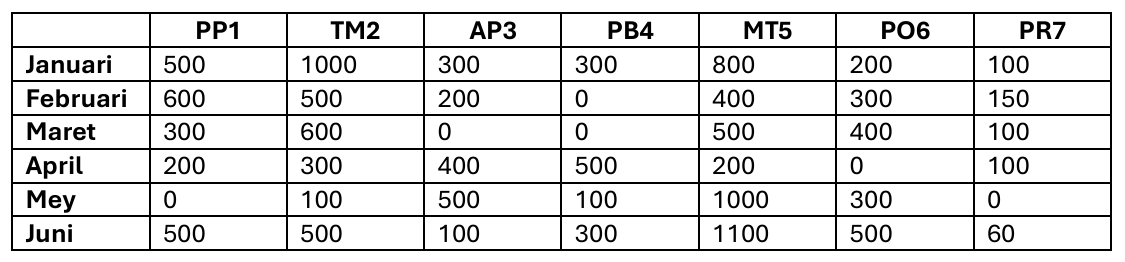

Perusahaan juga dapat menyimpan inventaris hingga 100 unit per produk dengan biaya penyimpanan sebesar Rp 50.000 per unit per bulan. Di akhir periode (Juni), harus tersedia minimal 50 unit setiap produk untuk persiapan musim panen. Pabrik beroperasi 6 hari per minggu dengan 2 shift per hari (@8 jam), dan setiap bulan dianggap memiliki 24 hari kerja. Saat ini tidak ada stok awal produk.

Tujuan dari studi kasus ini adalah untuk mengembangkan strategi produksi yang optimal selama enam bulan ke depan guna memaksimalkan total keuntungan, dengan mempertimbangkan: kapasitas mesin dan jadwal pemeliharaan, batasan penjualan, biaya penyimpanan dan persyaratan stok akhir, efisiensi produksi dan profitabilitas secara keseluruhan.

##**Penyelesaian**

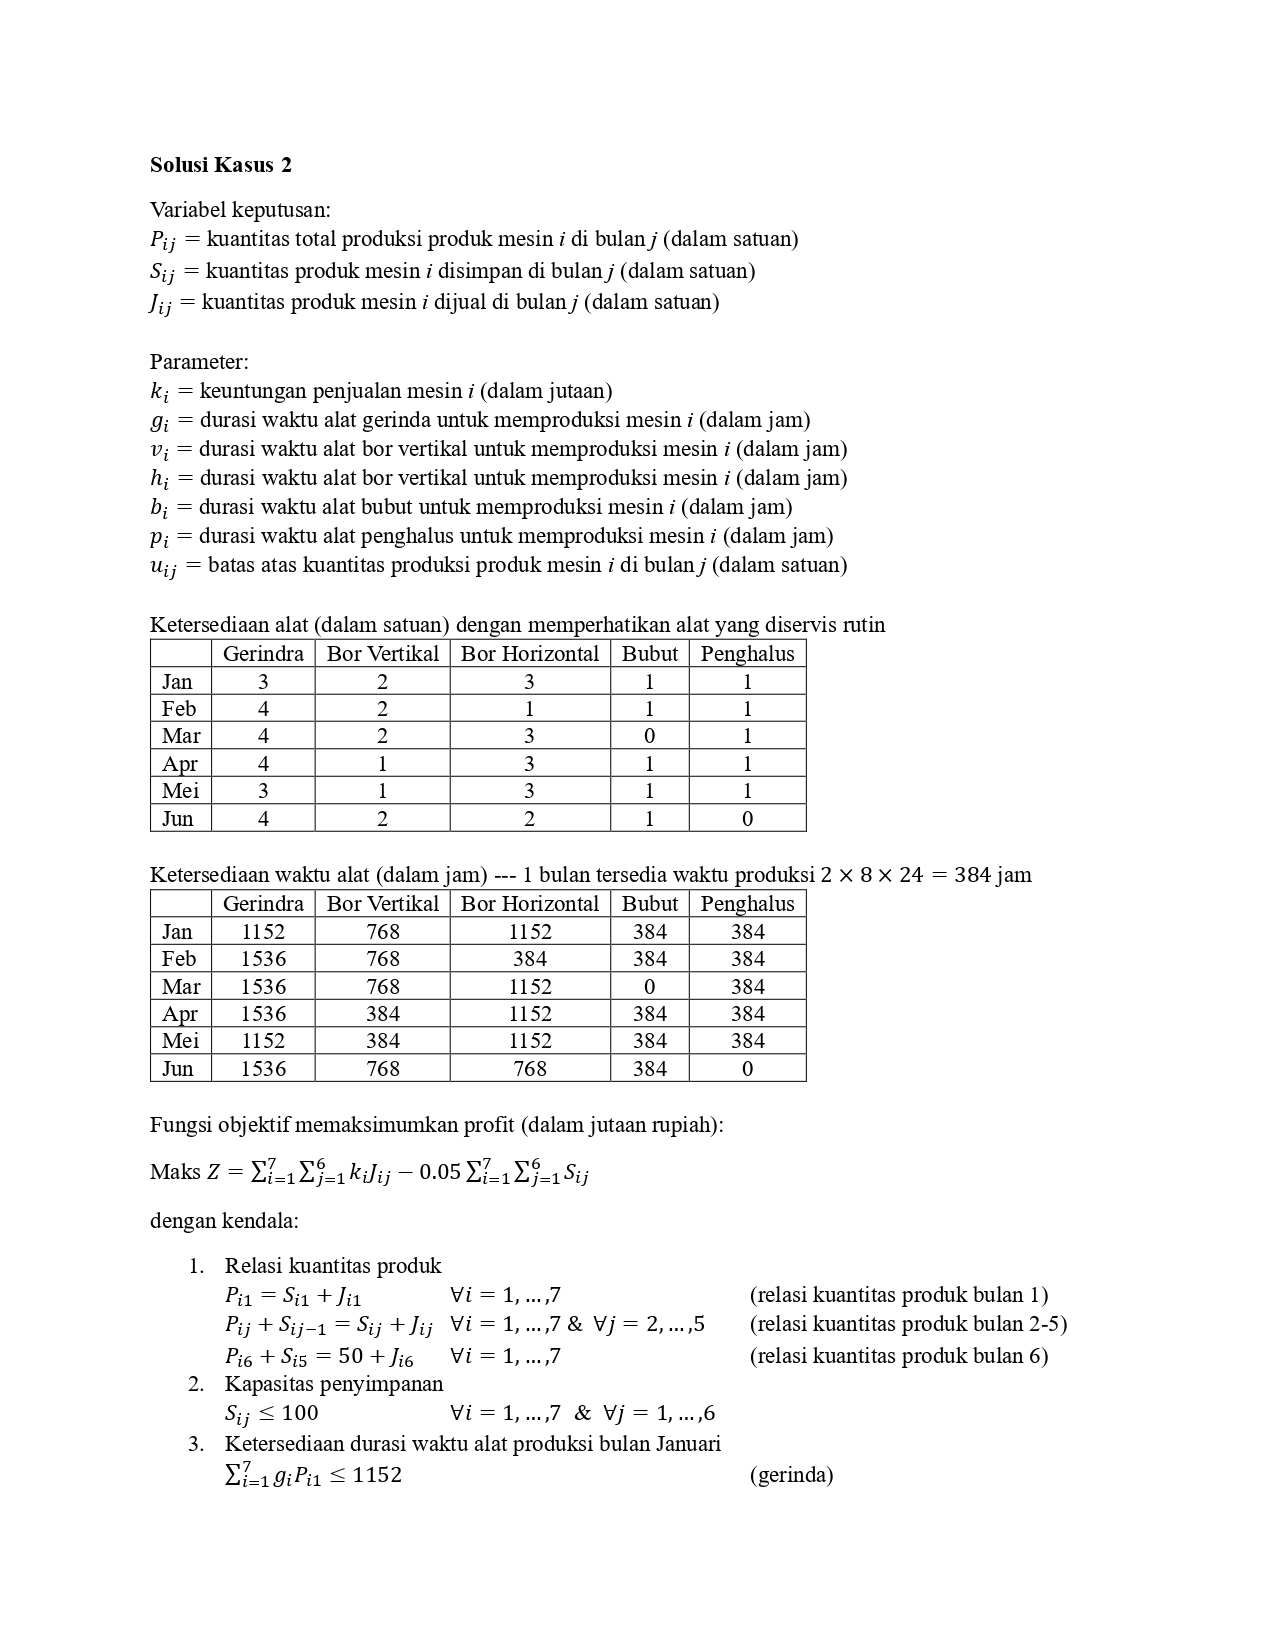

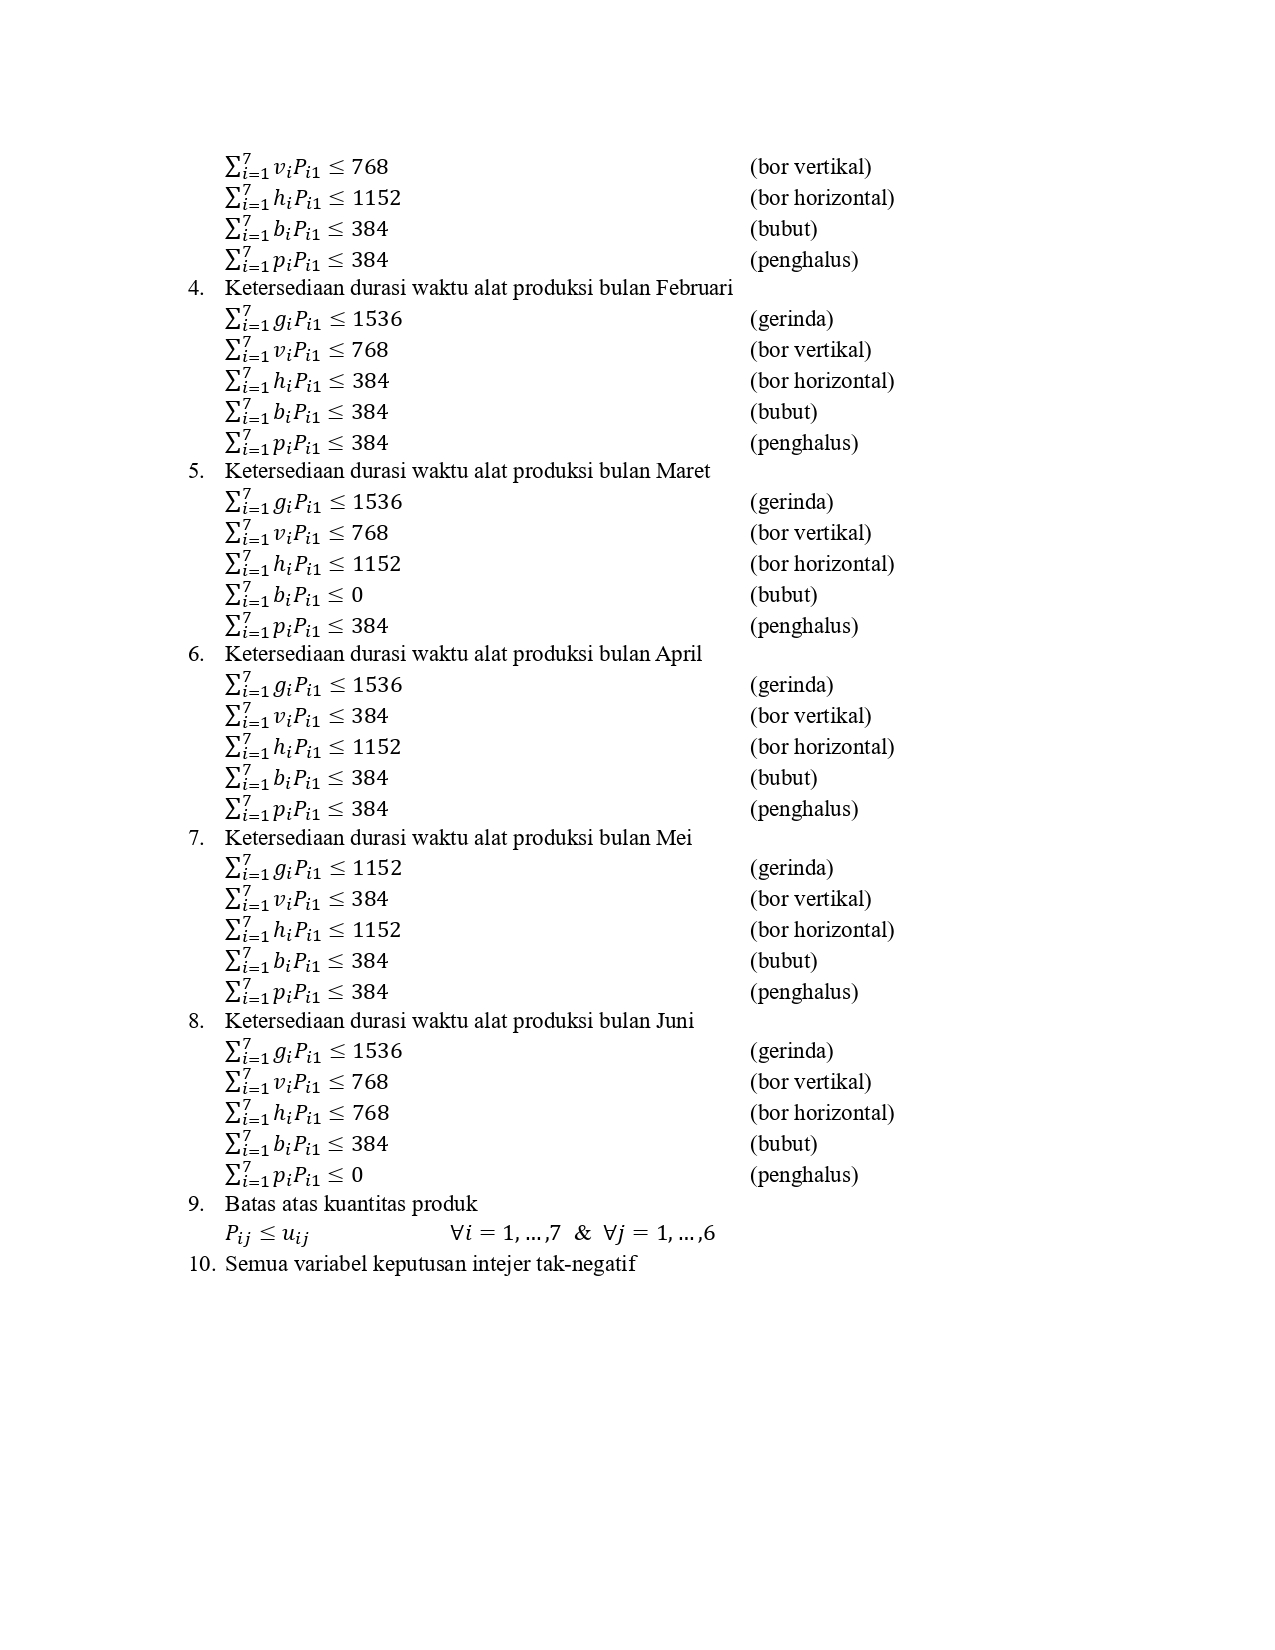

##**Implementasi Pyomo**

In [3]:
!pip install pyomo
!apt-get install -y -qq glpk-utils

In [2]:
from pyomo.environ import *

In [5]:
# Data keuntungan penjualan mesin
profit = [10,6,8,4,11,9,3]

# Data durasi waktu alat untuk memproduksi mesin
durasi = [
    [0.5,0.1,0.2,0.05,0   ],
    [0.7,0.2,0  ,0.03,0   ],
    [0  ,0  ,0.8,0   ,0.01],
    [0  ,0.3,0  ,0.07,0   ],
    [0.3,0  ,0  ,0.1 ,0.05],
    [0.2,0.6,0  ,0   ,0   ],
    [0.5,0  ,0.6,0.08,0.05]]

# Data batasan pemasaran
batas = [
    [500,600,300,200,0,500],
    [1000,500,600,300,100,500],
    [300,200,0,400,500,100],
    [300,0,0,500,100,300],
    [800,400,500,200,1000,1100],
    [200,300,400,0,300,500],
    [100,150,100,100,0,60]]

# Data ketersediaan waktu alat
tersedia = [
    [1152,768,1152,384,384],
    [1536,768,384,384,384],
    [1536,768,1152,0,384],
    [1536,384,1152,384,384],
    [1152,384,1152,384,384],
    [1536,768,768,384,0]]

# Model
model = ConcreteModel()

# Indeks
model.M = RangeSet(1,7)
model.N = RangeSet(1,6)
model.O = RangeSet(1,5)

# Variabel keputusan
model.p = Var(model.M,model.N, within=NonNegativeIntegers)
model.s = Var(model.M,model.N, within=NonNegativeIntegers)
model.ju = Var(model.M,model.N, within=NonNegativeIntegers)

# Parameter
model.ke = Param(model.M, initialize=lambda model, i: profit[i - 1])
model.a = Param(model.M, model.O,initialize=lambda model, i, k: durasi[i-1][k-1])
model.u = Param(model.M, model.N,initialize=lambda model, i, j: batas[i-1][j-1])
model.w = Param(model.N, model.O,initialize=lambda model, j, k: tersedia[j-1][k-1])

# Objektif: Memaksimumkan profit (dalam jutaan rupiah)
def obj_func(model):
    return sum(model.ke[i] * model.ju[i,j] for i in model.M for j in model.N) - 0.05 * sum(model.s[i,j] for i in model.M for j in model.N)
model.objective = Objective(rule=obj_func,sense=maximize)

# Relasi kuantitas produk
def rule_const1_1(model,M):
    return model.p[M,1] == model.s[M,1] + model.ju[M,1]
model.const1_1 = Constraint(model.M,rule=rule_const1_1)

def rule_const1_2(model,M,N):
    if N!=1&N!=6:
        return model.p[M,N] + model.s[M,N-1] == model.s[M,N] + model.ju[M,N]
    else:
        return model.p[M,N]== model.p[M,N]
model.const1_2 = Constraint(model.M,model.N,rule=rule_const1_2)

def rule_const1_3(model,M):
    return model.p[M,6] + model.s[M,5] == 50 + model.ju[M,6]
model.const1_3 = Constraint(model.M,rule=rule_const1_3)

# Kapasitas penyimpanan
def rule_const2(model,M,N):
    return model.s[M,N] <= 100
model.const2 = Constraint(model.M,model.N,rule=rule_const2)

# Ketersediaan durasi waktu alat produksi
def rule_const3(model,N,O):
    return sum(model.a[i,O] * model.p[i,N] for i in model.M) <= model.w[N,O]
model.const3 = Constraint(model.N,model.O,rule=rule_const3)

# Batas atas kuantitas produk
def rule_const4(model,M,N):
    return model.p[M,N] <= model.u[M,N]
model.const4 = Constraint(model.M,model.N,rule=rule_const4)

# Penyelesaian - menggunakan solver GLPK
result = SolverFactory('glpk').solve(model)

# Display output nilai variabel keputusan
print(f'Status solusi: {result.solver.termination_condition}')
print('Nilai fungsi objektif:',model.objective(),"\n")

L1 = list(model.p.keys())
for i in L1:
        print('P',i,model.p[i]())
print()

L2 = list(model.s.keys())
for i in L2:
        print('S',i,model.s[i]())
print()

L3 = list(model.ju.keys())
for i in L3:
        print('J',i,model.ju[i]())


Status solusi: optimal
Nilai fungsi objektif: 87600.5 

P (1, 1) 500.0
P (1, 2) 600.0
P (1, 3) 0.0
P (1, 4) 200.0
P (1, 5) 0.0
P (1, 6) 500.0
P (2, 1) 887.0
P (2, 2) 500.0
P (2, 3) 0.0
P (2, 4) 300.0
P (2, 5) 100.0
P (2, 6) 500.0
P (3, 1) 300.0
P (3, 2) 200.0
P (3, 3) 0.0
P (3, 4) 400.0
P (3, 5) 500.0
P (3, 6) 0.0
P (4, 1) 300.0
P (4, 2) 0.0
P (4, 3) 0.0
P (4, 4) 500.0
P (4, 5) 100.0
P (4, 6) 300.0
P (5, 1) 800.0
P (5, 2) 400.0
P (5, 3) 0.0
P (5, 4) 200.0
P (5, 5) 1000.0
P (5, 6) 0.0
P (6, 1) 200.0
P (6, 2) 300.0
P (6, 3) 400.0
P (6, 4) 0.0
P (6, 5) 300.0
P (6, 6) 500.0
P (7, 1) 2.0
P (7, 2) 150.0
P (7, 3) 0.0
P (7, 4) 100.0
P (7, 5) 0.0
P (7, 6) 0.0

S (1, 1) 0.0
S (1, 2) 0.0
S (1, 3) 0.0
S (1, 4) 0.0
S (1, 5) 0.0
S (1, 6) 50.0
S (2, 1) 0.0
S (2, 2) 0.0
S (2, 3) 0.0
S (2, 4) 0.0
S (2, 5) 0.0
S (2, 6) 50.0
S (3, 1) 0.0
S (3, 2) 0.0
S (3, 3) 0.0
S (3, 4) 0.0
S (3, 5) 50.0
S (3, 6) 50.0
S (4, 1) 0.0
S (4, 2) 0.0
S (4, 3) 0.0
S (4, 4) 0.0
S (4, 5) 0.0
S (4, 6) 50.0
S (5, 1) 0.0
S (5, 2) 0



---

Berdasarkan hasil solusi optimal model optimasi produksi, PT Agro Inovasi Bogor dapat mencapai total keuntungan sebesar **Rp 87,6 miliar** selama periode enam bulan dengan strategi produksi yang terencana. Solusi ini telah mempertimbangkan seluruh kendala operasional, termasuk kapasitas mesin, jadwal pemeliharaan, batas penjualan, dan kebutuhan persediaan akhir.

**Strategi Produksi**\
Perusahaan memprioritaskan produksi mesin dengan margin keuntungan tertinggi:
- Mesin Tanam (MT5) yang memberikan keuntungan Rp 11 juta per unit diproduksi secara maksimal pada bulan-bulan permintaan tinggi (Januari, Februari, dan Mei).
- Pemanen Padi (PP1) dengan keuntungan Rp 10 juta per unit diproduksi sesuai batas pasar, kecuali pada bulan Maret dan Mei dimana produksi dihentikan sementara untuk mengoptimalkan alokasi sumber daya.

**Pengelolaan Persediaan**\
Strategi penyimpanan diterapkan secara hemat dan hanya untuk memenuhi kebutuhan akhir periode:
- Hanya produk Alat Penyemprot (AP3), Mesin Tanam (MT5), dan Pemotong Rumput (PR7) yang memerlukan penumpukan stok sebelum bulan Juni.
- Biaya penyimpanan berhasil diminimalkan karena tidak ada kelebihan stok yang tidak perlu selama periode produksi.

**Pemanfaatan Kapasitas**\
Model menunjukkan pemanfaatan mesin yang sangat efisien:
- Pada bulan Januari, produksi Traktor Mini (TM2) sengaja ditingkatkan menjadi 887 unit (mendekati batas maksimal pemasaran 1000 unit) untuk memanfaatkan kapasitas mesin yang masih longgar.
- Produksi diatur untuk menghindari konflik dengan jadwal pemeliharaan, seperti menghentikan sementara produksi beberapa produk pada bulan Maret.